# Poisson 3d for arbitrary metric with FEEC

In [2]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import time

import psydac.core.interface as inter

import utilitis_FEEC.derivatives as der
import utilitis_FEEC.projectors as proj
import utilitis_FEEC.evaluation as eva
import utilitis_FEEC.integrate as integr
import utilitis_FEEC.mass_matrices_curved as ma

In [404]:
# ... define boundary conditions in each direction (True: periodic, False: homogeneous Dirichlet)
bc = [False, True, True]
bc_x, bc_y, bc_z = bc


# ... length of computational domain in each direction
Lx = 1.
Ly = 1.
Lz = 1.


# ... number of elements in each direction and corresponding element boundaries
Nel_x = 10
Nel_y = 2
Nel_z = 2

dx = Lx/Nel_x
dy = Ly/Nel_y
dz = Lz/Nel_z

el_b_x = np.linspace(0, Lx, Nel_x + 1)
el_b_y = np.linspace(0, Ly, Nel_y + 1)
el_b_z = np.linspace(0, Lz, Nel_z + 1)


# ... degree of spline basis (of the 0-forms) in each direction
p = [2, 2, 2]
px, py, pz = p


# ... number of basis functions
Nbase = [Nel_x + px, Nel_y + py, Nel_z + pz] 
Nbase_x, Nbase_y, Nbase_z = Nbase



# ... knot vectors and number of degrees of freedom
if bc_x == True:
    Tx = inter.make_periodic_knots(px, Nbase_x)
    Nbase_x_0 = Nbase_x - px
    
elif bc_x == False:
    Tx = inter.make_open_knots(px, Nbase_x)
    Nbase_x_0 = Nbase_x - 2
    
else:
    Tx = inter.make_open_knots(px, Nbase_x)
    Nbase_x_0 = Nbase_x

    
if bc_y == True:
    Ty = inter.make_periodic_knots(py, Nbase_y)
    Nbase_y_0 = Nbase_y - py
    
elif bc_y == False:
    Ty = inter.make_open_knots(py, Nbase_y)
    Nbase_y_0 = Nbase_y - 2
    
else:
    Ty = inter.make_open_knots(py, Nbase_y)
    Nbase_y_0 = Nbase_y
    

if bc_z == True:
    Tz = inter.make_periodic_knots(pz, Nbase_z)
    Nbase_z_0 = Nbase_z - pz
    
elif bc_z == False:
    Tz = inter.make_open_knots(pz, Nbase_z)
    Nbase_z_0 = Nbase_z - 2
    
else:
    Tz = inter.make_open_knots(pz, Nbase_z)
    Nbase_z_0 = Nbase_z
    
T = [Tx, Ty, Tz]



# ... define physical domain and mapping from logical domain
R0 = 1.5
R1 = 0.1
R2 = 1.0
dR = R2 - R1

#r, phi, z = sym.symbols('r, phi, z')
#q = sym.Matrix([r, phi, z])

r, theta, phi = sym.symbols('r, theta, phi')
q = sym.Matrix([r, theta, phi])

# ... mapping
#F = sym.Matrix([(r*dR + R1)*sym.cos(2*sym.pi*phi), (r*dR + R1)*sym.sin(2*sym.pi*phi), z])
F = sym.Matrix([(R0 + (r*dR + R1)*sym.cos(2*sym.pi*theta))*sym.cos(2*sym.pi*phi), (R0 + (r*dR + R1)*sym.cos(2*sym.pi*theta))*sym.sin(2*sym.pi*phi), (r*dR + R1)*sym.sin(2*sym.pi*theta)])
#F = sym.Matrix([r, phi, z])

# ... jacobian
DF = F.jacobian(q)

# ... metric tensor
G = sym.simplify(DF.transpose()*DF)

# ... inverse of metric tensor
Ginv = G.inverse()

#... square root of jacobi determinant
g = sym.simplify(G.det())
g_sqrt = sym.sqrt(g)

In [406]:
# ... create model with method of manufactured solutions
phi0 = r*sym.sin(2*sym.pi*r)

dphi0 = sym.Matrix([sym.diff(phi0, r), sym.diff(phi0, phi), sym.diff(phi0, z)])
temp = g_sqrt*Ginv*dphi0

f3 = -(sym.diff(temp[0], r) + sym.diff(temp[1], phi) + sym.diff(temp[2], z))
hodge_f3 = 1/g_sqrt*f3

phi0 = sym.lambdify(q, phi0)
hodge_f3 = sym.lambdify(q, hodge_f3)

# ... convert mapping functions to callables
xc = sym.lambdify(q, F[0])
yc = sym.lambdify(q, F[1])
zc = sym.lambdify(q, F[2])

G = [[sym.lambdify(q, G[0, 0]), sym.lambdify(q, G[0, 1]), sym.lambdify(q, G[0, 2])], [sym.lambdify(q, G[1, 0]), sym.lambdify(q, G[1, 1]), sym.lambdify(q, G[1, 2])], [sym.lambdify(q, G[2, 0]), sym.lambdify(q, G[2, 1]), sym.lambdify(q, G[2, 2])]]
Ginv = [[sym.lambdify(q, Ginv[0, 0]), sym.lambdify(q, Ginv[0, 1]), sym.lambdify(q, Ginv[0, 2])], [sym.lambdify(q, Ginv[1, 0]), sym.lambdify(q, Ginv[1, 1]), sym.lambdify(q, Ginv[1, 2])], [sym.lambdify(q, Ginv[2, 0]), sym.lambdify(q, Ginv[2, 1]), sym.lambdify(q, Ginv[2, 2])]]
g = sym.lambdify(q, g)
g_sqrt = sym.lambdify(q, g_sqrt)

In [407]:
# ... mass matrix in M1
M1 = ma.mass_matrix_V1(p, Nbase, T, Ginv, g_sqrt, bc)

In [408]:
# ... discrete gradient matrix
GRAD = der.GRAD_3d(p, Nbase, bc)

In [409]:
# ... L2-scalar product of source function in V0
fint = ma.L2_prod_V0(hodge_f3, p, Nbase, T, g_sqrt, bc)

In [410]:
# ... assemble linear system
Block_01 = M1.dot(GRAD)
Block_10 = GRAD.T.dot(M1)
Block_11 = np.zeros((Block_10.shape[0], Block_01.shape[1]))

RHS = np.append(np.zeros(M1.shape[0]), np.reshape(fint, Nbase_x_0*Nbase_y_0*Nbase_z_0))

K = sparse.bmat([[-M1, Block_01], [Block_10, Block_11]], format='csr')

In [411]:
# ... solve linear system
res = sparse.linalg.spsolve(K, RHS)
phivec = res[M1.shape[0]:]

Text(0,0.5,'z')

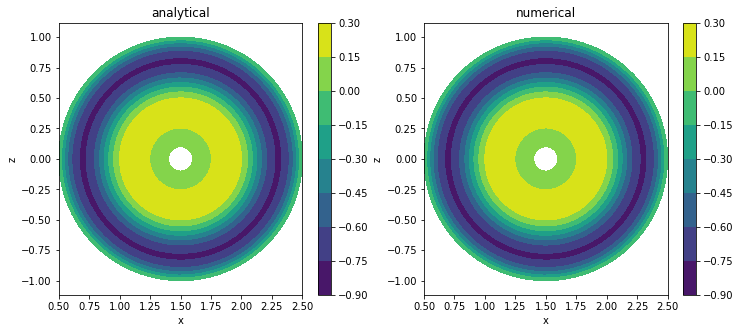

In [412]:
# ... plot analytical and numerical solution
zplot = np.array([0.0])
rplot = np.linspace(0., 1., 100)
phiplot = np.linspace(0., 1., 100)

R, PHI = np.meshgrid(rplot, phiplot, indexing = 'ij')

PHI0 = phi0(R, PHI, zplot)

PHI0_h = eva.evaluate_field_V0(phivec, [rplot, phiplot, zplot], p, Nbase, T, bc)
PHI0_h = np.reshape(PHI0_h, (100, 100))

#X, Y = xc(R, PHI, zplot), yc(R, PHI, zplot)
X, Z = xc(R, PHI, zplot), zc(R, PHI, zplot)

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(5)

plt.subplot(1, 2, 1)

plt.contourf(X, Z, PHI0)
plt.colorbar()
plt.axis('equal')
plt.title('analytical')
plt.xlabel('x')
plt.ylabel('z')


plt.subplot(1, 2, 2)

plt.contourf(X, Z, PHI0_h)
plt.colorbar()
plt.axis('equal')
plt.title('numerical')
plt.xlabel('x')
plt.ylabel('z')

In [413]:
# convergence in L2-norm

cases_e = 5
cases_p = 2

L2_error = np.zeros((cases_e, cases_p))
H = np.zeros((cases_e, cases_p))

for j in range(2, cases_p + 2):
    for i in range(1, cases_e + 1):

        # ... number of elements and element boundaries in each direction (on patch)
        Nel_x = 2*2**i
        Nel_y = 2
        Nel_z = 2

        el_b_x = np.linspace(0., 1., Nel_x + 1)
        el_b_y = np.linspace(0., 1., Nel_y + 1)
        el_b_z = np.linspace(0., 1., Nel_z + 1)

        dx = 1/Nel_x
        dy = 1/Nel_y
        dz = 1/Nel_z

        # ... degree of spline basis (of the 0-forms) in each direction
        p = [j, 2, 2]
        px, py, pz = p


        # ... number of basis functions
        Nbase = [Nel_x + px, Nel_y + py, Nel_z + pz] 
        Nbase_x, Nbase_y, Nbase_z = Nbase



        # ... knot vectors and number of degrees of freedom
        if bc_x == True:
            Tx = inter.make_periodic_knots(px, Nbase_x)
            Nbase_x_0 = Nbase_x - px

        elif bc_x == False:
            Tx = inter.make_open_knots(px, Nbase_x)
            Nbase_x_0 = Nbase_x - 2

        else:
            Tx = inter.make_open_knots(px, Nbase_x)
            Nbase_x_0 = Nbase_x


        if bc_y == True:
            Ty = inter.make_periodic_knots(py, Nbase_y)
            Nbase_y_0 = Nbase_y - py

        elif bc_y == False:
            Ty = inter.make_open_knots(py, Nbase_y)
            Nbase_y_0 = Nbase_y - 2

        else:
            Ty = inter.make_open_knots(py, Nbase_y)
            Nbase_y_0 = Nbase_y


        if bc_z == True:
            Tz = inter.make_periodic_knots(pz, Nbase_z)
            Nbase_z_0 = Nbase_z - pz

        elif bc_z == False:
            Tz = inter.make_open_knots(pz, Nbase_z)
            Nbase_z_0 = Nbase_z - 2

        else:
            Tz = inter.make_open_knots(pz, Nbase_z)
            Nbase_z_0 = Nbase_z

        T = [Tx, Ty, Tz]


        # ... mass matrix in V1 and discrete gradient matrix
        M1 = ma.mass_matrix_V1(p, Nbase, T, Ginv, g_sqrt, bc)
        G = der.GRAD_3d(p, Nbase, bc)

        # ... L2-scalar product of source function in V0
        fint = ma.L2_prod_V0(hodge_f3, p, Nbase, T, g_sqrt, bc)

        # ... assemble linear system
        Block_01 = M1.dot(G)
        Block_10 = G.T.dot(M1)
        Block_11 = np.zeros((Block_10.shape[0], Block_01.shape[1]))

        RHS = np.append(np.zeros(M1.shape[0]), np.reshape(fint, Nbase_x_0*Nbase_y_0*Nbase_z_0))

        K = sparse.bmat([[-M1, Block_01], [Block_10, Block_11]], format='csr')

        # ... solve linear system
        res = sparse.linalg.spsolve(K, RHS)
        phivec = res[M1.shape[0]:]

        # ... L2 error
        pts_x_loc, wts_x_loc = np.polynomial.legendre.leggauss(px + 1)
        pts_y_loc, wts_y_loc = np.polynomial.legendre.leggauss(py + 1)
        pts_z_loc, wts_z_loc = np.polynomial.legendre.leggauss(pz + 1)

        pts_x, wts_x = inter.construct_quadrature_grid(Nel_x, px + 1, pts_x_loc, wts_x_loc, el_b_x)
        pts_y, wts_y = inter.construct_quadrature_grid(Nel_y, py + 1, pts_y_loc, wts_y_loc, el_b_y)
        pts_z, wts_z = inter.construct_quadrature_grid(Nel_z, pz + 1, pts_z_loc, wts_z_loc, el_b_z)

        ff = np.empty((px + 1, py + 1, pz + 1, Nel_x, Nel_y, Nel_z), order='F') 


        for nx in range(Nel_x):
            for ny in range(Nel_y):
                for nz in range(Nel_z):

                    ptx = pts_x[:, nx]
                    pty = pts_y[:, ny]
                    ptz = pts_z[:, nz]

                    R, PHI, Z = np.meshgrid(ptx, pty, ptz, indexing='ij')

                    PHI0 = phi0(R, PHI, Z)

                    PHI0_h = eva.evaluate_field_V0(phivec, [ptx, pty, ptz], p, Nbase, T, bc)
                    PHI0_h = np.reshape(PHI0_h, (px + 1, py + 1, pz + 1))


                    ff[:, :, :, nx, ny, nz] = (PHI0 - PHI0_h)**2*g_sqrt(R, PHI, Z)  



        L2_error[i - 1, j - 2] = np.sqrt(integr.integrate_3d_fast([pts_x, pts_y, pts_z], [wts_x, wts_y, wts_z], ff).sum()) 
        print('case ' + str(i) + ' done!: error = ' + str(L2_error[i - 1, j - 2]))

        H[i - 1, j - 2] = dx

case 1 done!: error = 0.13177364779039039
case 2 done!: error = 0.009678269580308228
case 3 done!: error = 0.0009502266354308057
case 4 done!: error = 0.00011026023106240183
case 5 done!: error = 1.3511296456259965e-05
case 1 done!: error = 0.028841326074689835
case 2 done!: error = 0.001616200615509946
case 3 done!: error = 8.631292064026111e-05
case 4 done!: error = 5.160333646871877e-06
case 5 done!: error = 3.195268560215111e-07


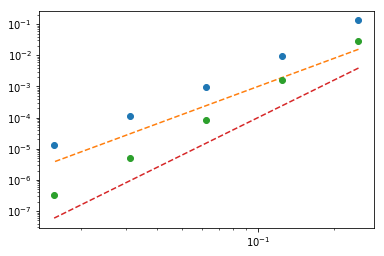

In [414]:
for j in range(cases_p):
    plt.loglog(H[:, j], L2_error[:, j], 'o')
    plt.loglog(H[:, j], H[:, j]**(j + 3), '--')